In [2]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *
from tqdm import tqdm

from scipy.interpolate import griddata
from scipy import interpolate

# Analysis Glider Reanalysis EuroSea

In [3]:
simulations = {"CR": F"//mnt/vinson/DATA/modelling/WMOP_REANALYSIS/Outputs/EUROSEA_T4_FreeRun/forecast_scratch/",
               "noGLI": F"/mnt/vinson/DATA/modelling/WMOP_REANALYSIS/Outputs/EUROSEA_T4_noGLIDERS/forecast_scratch/",
               "GLI": F"/mnt/vinson/DATA/modelling/WMOP_REANALYSIS/Outputs/EUROSEA_T4_GLIDERS/forecast_scratch/"
              }

## 1 - SLA gridded vs Model

In [3]:
%%capture
from collections import defaultdict

# Load MDT
mdt_filename = '/mnt/vinson/data/modelling/WMOP_ASSIM/Inputs/roms_WMOP_HINDCAST_synthetic_201505_201804_mean.nc'
ds_mdt = xr.open_dataset(mdt_filename)

# Select Days
date = datetime(2017,1,1)
date_end = datetime(2017,12,31)
ndays = (date_end - date).days

rmsd_sla = defaultdict(list)
corr_sla = defaultdict(list)

for i in tqdm(range(ndays)):
    
    ds_sla = tools.get_altimetry_data(date.strftime('%Y%m%d'), 'rep_map_sla', timewindow=1, limits=[-6, 9.2, 35, 44.5])

    ny, nx = ds_sla.sla.shape[1:]

    for sim in simulations:

        ds_wmop = xr.open_dataset(glob(F"{simulations[sim]}/*{date.strftime('%Y%m%d')}*avg*")[0])

        # Create grid of Points to interpolate to
        xx, yy = np.meshgrid(ds_sla.longitude, ds_sla.latitude)
        xx = xx.flatten()
        yy = yy.flatten()
        # Set grid Lon, Lat from altimetry as tuple of arrays
        lonlat = np.array([xx,yy]).T

        points = np.array([ds_wmop.lon_rho.values.flatten(), ds_wmop.lat_rho.values.flatten()]).T
        # Get SLA and put as array
        sla_wmop = (ds_wmop.zeta[0,:,:] - ds_mdt.zeta[0,:,:]).values.flatten() 
        
        # Grid WMOP SLA to Altimetry points
        sla_interp = griddata(points, sla_wmop, lonlat, method='nearest')
        sla_interp = np.reshape(sla_interp, (ny,nx))
        
        # Calculate RMSD
        rmsd_sla[sim].append( np.sqrt( np.nanmean( (sla_interp - ds_sla.sla[0,:,:].values)**2 ) ) )
        
        # Calculate Correlation
        ii = ~np.isnan(sla_interp.flatten()) & ~np.isnan(ds_sla.sla[0,:,:].values.flatten())
        corr_sla[sim].append( np.corrcoef(sla_interp.flatten()[ii], ds_sla.sla[0,:,:].values.flatten()[ii] )[0][1] )
    
    date = date + timedelta(days=1)

**Plot RMSD and Correlation**

In [4]:
date_ini = datetime(2017,1,1)
days = pd.date_range(date_ini, date_end, freq='1D')

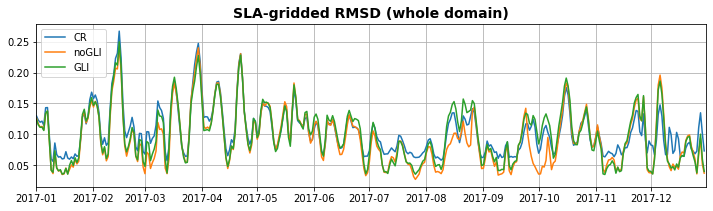

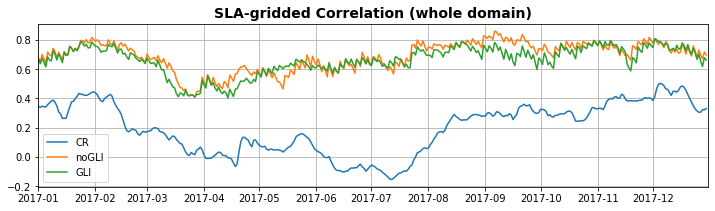

In [5]:
fig_sla_rmsd = plt.figure(figsize=(12,3))
for sim in simulations:
    plt.plot(days[0:-1], rmsd_sla[sim], label=sim)
    
plt.title('SLA-gridded RMSD (whole domain)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((days[0], days[-1]))
plt.show()
fig_sla_rmsd.savefig('/LOCALDATA/Plots/EuroSea/WP4/Eurosea_reanalysis_2017_rmsd_SLA.png', dpi=250, transparent=False, facecolor="w")

# Correlation
fig_sla_corr = plt.figure(figsize=(12,3))
for sim in simulations:
    plt.plot(days[0:-1], corr_sla[sim], label=sim)
    
plt.title('SLA-gridded Correlation (whole domain)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((days[0], days[-1]))
plt.show()

fig_sla_corr.savefig('/LOCALDATA/Plots/EuroSea/WP4/Eurosea_reanalysis_2017_corr_SLA.png', dpi=250, transparent=False, facecolor="w")


**Normalized RMSD**

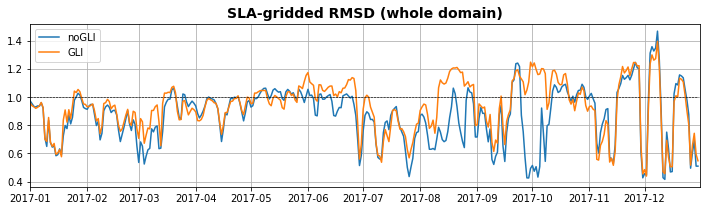

In [91]:
plt.figure(figsize=(12,3))
for sim in ['noGLI', 'GLI']:
    plt.plot(days[0:-1], np.array(rmsd_sla[sim]) / np.array(rmsd_sla['CR']), label=sim)
plt.plot(  days[0:-1], np.array(rmsd_sla[sim]) * 0 + 1, 'k--', linewidth=0.6)  
    
plt.title('SLA-gridded RMSD (whole domain)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((days[0], days[-1]))
plt.show()


In [6]:
for sim in simulations:
    print(F"{sim} RMSD =  {np.nanmean(rmsd_sla[sim]):0.3f}")
    print(F"     Corr =  {np.nanmean(corr_sla[sim]):0.3f}")

CR RMSD =  0.104
     Corr =  0.198
noGLI RMSD =  0.093
     Corr =  0.688
GLI RMSD =  0.099
     Corr =  0.662


## 2 - SST vs Model at 6am

In [7]:
date = datetime(2017,1,1)
ds_sst = tools.get_CMEMS_OISST(date.strftime('%Y%m%d'), product='L4_UHR', 
                               limits=[-6, 9.2, 35, 44.5], sst_interpolated=True, 
                               smooth=False, resolution=10)

In [10]:
%%capture
from collections import defaultdict
import os

# Load MDT
mdt_filename = '/mnt/vinson/data/modelling/WMOP_ASSIM/Inputs/roms_WMOP_HINDCAST_synthetic_201505_201804_mean.nc'
ds_mdt = xr.open_dataset(mdt_filename)

# Select Days
date = datetime(2017,1,1)
date_end = datetime(2017,12,31)
ndays = (date_end - date).days

rmsd_sst = defaultdict(list)
corr_sst = defaultdict(list)

for i in tqdm(range(ndays)):
    
    ds_sst = tools.get_CMEMS_OISST(date.strftime('%Y%m%d'), product='L4_UHR', 
                               limits=[-6, 9.2, 35, 44.5], sst_interpolated=True, 
                               smooth=False, resolution=10)
    os.remove(glob('./*OISST*nc*')[0])

    ny, nx = ds_sst.analysed_sst.shape[1:]

    for sim in simulations:

        ds_wmop = xr.open_dataset(glob(F"{simulations[sim]}/*{date.strftime('%Y%m%d')}*his*")[0])

        # Create grid of Points to interpolate to
        xx, yy = np.meshgrid(ds_sst.lon, ds_sst.lat)
        xx = xx.flatten()
        yy = yy.flatten()
        # Set grid Lon, Lat from altimetry as tuple of arrays
        lonlat = np.array([xx,yy]).T

        points = np.array([ds_wmop.lon_rho.values.flatten(), ds_wmop.lat_rho.values.flatten()]).T
        # Get SLA and put as array
        sst_wmop = ds_wmop.temp[2,-1,:,:].values.flatten() 
        
        # Grid WMOP SST to satellite points
        sst_interp = griddata(points, sst_wmop, lonlat, method='nearest')
        sst_interp = np.reshape(sst_interp, (ny,nx))
        
        # Calculate RMSD
        rmsd_sst[sim].append( np.sqrt( np.nanmean( (sst_interp - (ds_sst.analysed_sst[0,:,:].values -273))**2 ) ) )
        # Calculate Correlation
        ii = ~np.isnan(sst_interp.flatten()) & ~np.isnan(ds_sst.analysed_sst[0,:,:].values.flatten())
        corr_sst[sim].append( np.corrcoef(sst_interp.flatten()[ii], ds_sst.analysed_sst[0,:,:].values.flatten()[ii] - 273 )[0][1] )
    
    date = date + timedelta(days=1)

**Plot RMSD and Correlation**

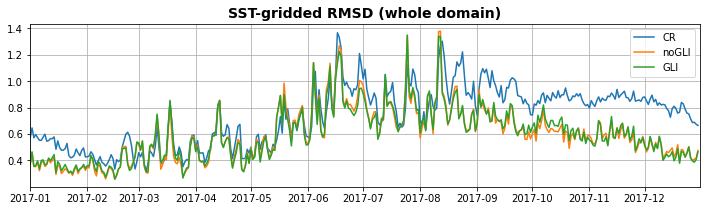

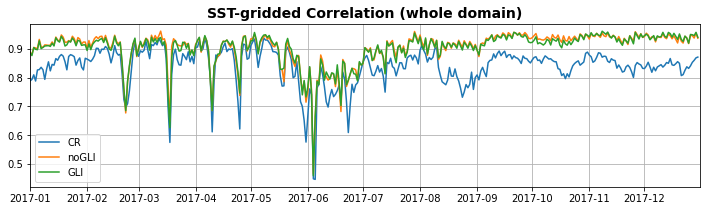

In [11]:
# RMSD
fig_sst_rmsd = plt.figure(figsize=(12,3))
for sim in simulations:
    plt.plot(days[0:-1], rmsd_sst[sim], label=sim)
    
plt.title('SST-gridded RMSD (whole domain)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((days[0], days[-1]))
plt.show()

# fig_sst_rmsd.savefig('/LOCALDATA/Plots/EuroSea/WP4/Eurosea_reanalysis_2017_rmsd_SST.png', dpi=250, transparent=False, facecolor="w")
# Correlation
fig_sst_corr = plt.figure(figsize=(12,3))
for sim in simulations:
    plt.plot(days[0:-1], corr_sst[sim], label=sim)
    
plt.title('SST-gridded Correlation (whole domain)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((days[0], days[-1]))
plt.show()

# fig_sst_corr.savefig('/LOCALDATA/Plots/EuroSea/WP4/Eurosea_reanalysis_2017_corr_SST.png', dpi=250, transparent=False, facecolor="w")

### Check SST variability

In [12]:
from collections import defaultdict

# Load MDT
mdt_filename = '/mnt/vinson/data/modelling/WMOP_ASSIM/Inputs/roms_WMOP_HINDCAST_synthetic_201505_201804_mean.nc'
ds_mdt = xr.open_dataset(mdt_filename)

# Select Days
date = datetime(2017,1,1)
date_end = datetime(2017,12,31)
# date_end = datetime(2017,1,3)
ndays = (date_end - date).days

std_mean_sst = defaultdict(list)

for i in tqdm(range(ndays)):
    

    for sim in simulations:

        ds_wmop = xr.open_dataset(glob(F"{simulations[sim]}/*{date.strftime('%Y%m%d')}*his*")[0])

       
        # Get SLA and put as array
        sst_wmop = ds_wmop.temp[:,-1,:,:]
        
        std_mean_sst[sim].append( np.nanmean(sst_wmop.std(axis=0)) )
        # Calculate Correlation
        # ii = ~np.isnan(sst_interp.flatten()) & ~np.isnan(ds_sst.analysed_sst[0,:,:].values.flatten())
        
    date = date + timedelta(days=1)

100%|██████████| 364/364 [09:00<00:00,  1.49s/it]


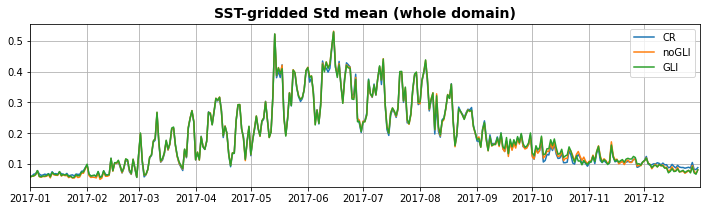

In [17]:
# RMSD
fig_sst_std = plt.figure(figsize=(12,3))
for sim in simulations:
    plt.plot(days[0:-1], std_mean_sst[sim], label=sim)
    
plt.title('SST-gridded Std mean (whole domain)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((days[0], days[-1]))
plt.show()

## 3 - Check RV vs Glider at Ibiza Channel

    Check if Data are consistent
    
    See if RV and Glider data are sinoptic
    

In [18]:
path_rv = "http://thredds.socib.es/thredds/dodsC/research_vessel/ctd/socib_rv-scb_sbe9002//L1_corr/2017/"
files_rv = [F'{path_rv}dep0033_socib-rv_scb-sbe9002_L1_corr_2017-07-26.nc',
            F'{path_rv}dep0029_socib-rv_scb-sbe9002_L1_corr_2017-05-12.nc',
            F'{path_rv}dep0027_socib-rv_scb-sbe9002_L1_corr_2017-02-14.nc']

In [19]:
ds_rv = xr.open_dataset(files_rv[0])

ds_rv.time

<xarray.DataArray 'time' (time: 33)>
array(['2017-07-26T09:49:44.000000000', '2017-07-26T10:10:49.000000000',
       '2017-07-26T10:52:55.000000000', '2017-07-26T11:29:21.000000000',
       '2017-07-26T12:07:17.000000000', '2017-07-26T12:42:31.000000000',
       '2017-07-26T13:31:18.000000000', '2017-07-26T14:22:56.000000000',
       '2017-07-26T15:18:41.000000000', '2017-07-26T16:11:16.000000000',
       '2017-07-26T16:53:08.000000000', '2017-07-27T05:39:44.000000000',
       '2017-07-27T06:21:25.000000000', '2017-07-27T07:04:14.000000000',
       '2017-07-27T08:06:00.000000000', '2017-07-27T09:14:00.000000000',
       '2017-07-27T10:20:30.000000000', '2017-07-27T11:39:49.000000000',
       '2017-07-27T13:13:09.000000000', '2017-07-27T14:15:02.000000000',
       '2017-07-28T08:36:16.000000000', '2017-07-28T09:11:23.000000000',
       '2017-07-28T09:44:39.000000000', '2017-07-28T10:32:47.000000000',
       '2017-07-28T12:10:02.000000000', '2017-07-28T13:49:33.000000000',
       '2017-07-28T15:03:32.000000000', '2017-07-28T16:15:15.000000000',
       '2017-07-28T18:13:08.000000000', '2017-07-28T18:41:45.000000000',
       '2017-07-29T09:13:55.000000000', '2017-07-29T09:52:49.000000000',
       '2017-07-29T10:33:31.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-07-26T09:49:44 ... 2017-07-29T10:33:31
    LAT      (time) float64 ...
    LON      (time) float64 ...
Attributes:
    standard_name:  time
    axis:           T

In [20]:
path_glider_cmems = '/home/modelling/data/Data/Observations/GLIDERS/CMEMS_EuroSea_T4.2/monthly/'

files_glider = glob(F'{path_glider_cmems}*201707*')
files_glider
# files_files = 

#F'{path_glider_cmems}GL_PR_GL_68967_201705.nc', F'{path_glider_cmems}GL_PR_GL_68967_201702.nc']

['/home/modelling/data/Data/Observations/GLIDERS/CMEMS_EuroSea_T4.2/monthly/GL_PR_GL_68457_201707.nc',
 '/home/modelling/data/Data/Observations/GLIDERS/CMEMS_EuroSea_T4.2/monthly/GL_PR_GL_68967_201707.nc',
 '/home/modelling/data/Data/Observations/GLIDERS/CMEMS_EuroSea_T4.2/monthly/GL_PR_GL_68968_201707.nc',
 '/home/modelling/data/Data/Observations/GLIDERS/CMEMS_EuroSea_T4.2/monthly/GL_PR_GL_68997_201707.nc']

SOCIB (Spain)
68457


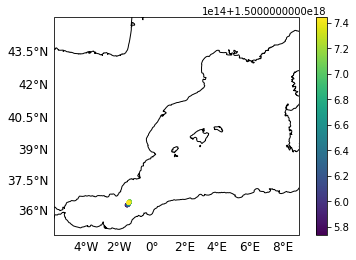

SOCIB (Spain)
68967


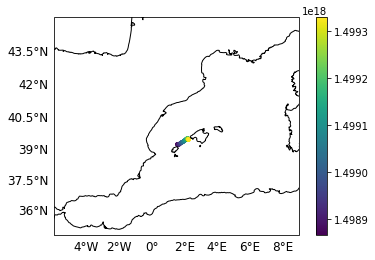

SOCIB (Spain)
68968


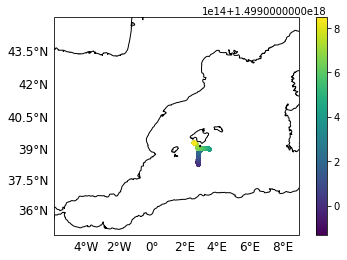

SOCIB (Spain)
68997


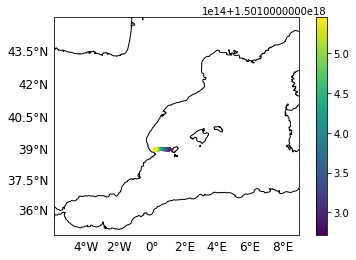

In [21]:
for f in files_glider:
    ds_g = xr.open_dataset(f)
    print(ds_g.institution)
    print(ds_g.platform_code)
    plt.figure()
    ax, gl = tools.make_map()#limits=[0,2,38.2,39.5])
    plt.scatter(ds_g.LONGITUDE, ds_g.LATITUDE, 10, ds_g.TIME, transform=gl.crs)
    plt.colorbar()
    plt.show()

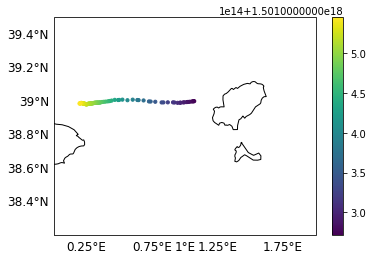

In [635]:

ax, gl = tools.make_map(limits=[0,2,38.2,39.5])
plt.scatter(ds_g.LONGITUDE, ds_g.LATITUDE, 10, ds_g.TIME, transform=gl.crs)
plt.colorbar()

In [636]:
pres = ds_g.PRES.values.flatten()
temp = ds_g.TEMP.values.flatten()
temp_qc = ds_g.TEMP_QC.values.flatten()
salt = ds_g.PSAL.values.flatten()
salt_qc = ds_g.PSAL_QC.values.flatten()

nz = ds_g.DEPTH.shape[0]
time = np.tile(ds_g.TIME.values,(nz,1)).T.flatten()
time = np.repeat(ds_g.TIME.values, nz)

ii = (~np.isnan(temp)) & (temp_qc==1) & (~np.isnan(pres)) 

# dens = sw.dens0(salt[ii], temp[ii])
dens = sw.pden(salt[ii], temp[ii], pres[ii])

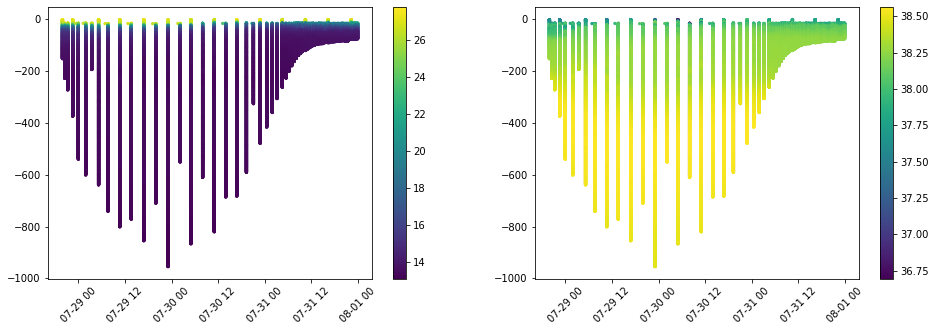

In [637]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(time[ii], -pres[ii], 5, temp[ii] )
plt.colorbar()
# plt.ylim((-100,0))
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.scatter(time[ii], -pres[ii], 5, salt[ii] )
plt.colorbar()
# plt.ylim((-100,0))
plt.xticks(rotation=45)


plt.show()

**Interpolate to regular grid**

In [638]:
dd = np.arange(0,800)
tt = np.arange(ds_g.TIME.shape[0])

xx, yy = np.meshgrid(tt, dd)

xx = xx.flatten()
yy = yy.flatten()
# Set grid Depth, Time from Glider observations as tuple of arrays
lonlat = np.array([xx,yy]).T


points = np.array([np.repeat(tt, nz)[ii], pres[ii]]).T
temp_interp = griddata(points, temp[ii], lonlat, method='nearest')
salt_interp = griddata(points, salt[ii], lonlat, method='nearest')
dens_interp = griddata(points, dens, lonlat, method='nearest')

In [639]:
temp_interp2 = np.reshape(temp_interp, (800, ds_g.TIME.shape[0]))
salt_interp2 = np.reshape(salt_interp, (800, ds_g.TIME.shape[0]))
dens_interp2 = np.reshape(dens_interp, (800, ds_g.TIME.shape[0]))
dens_interpc = dens_interp2.copy()
# gli_interp2.shape
for i in range(ds_g.TIME.shape[0]):
    max_level = int(ds_g.PRES[i,:].max().values.round())
    min_level = int(ds_g.PRES[i,:].min().values.round())
    # if max_level > 800:
    temp_interp2[max_level:,i] = np.nan; temp_interp2[:min_level+1,i] = np.nan
    salt_interp2[max_level:,i] = np.nan; salt_interp2[:min_level+1,i] = np.nan
    dens_interp2[max_level:,i] = np.nan; dens_interp2[:min_level+1,i] = np.nan

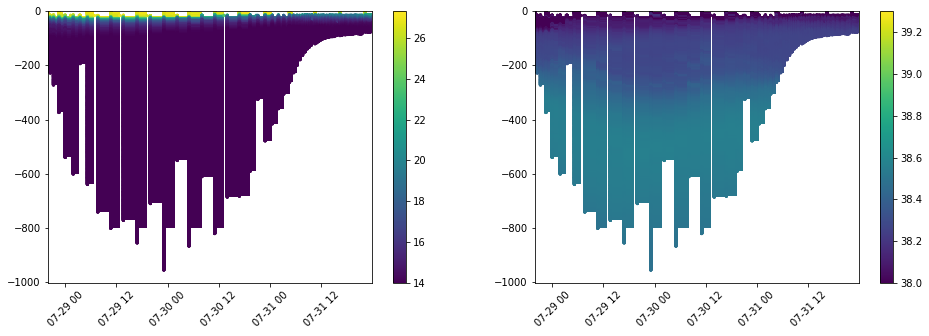

In [654]:

X, Y = np.meshgrid(ds_g.TIME.values, dd)


plt.figure(figsize=(16,5))
plt.subplot(1,2,1)

plt.pcolormesh(X, -Y, temp_interp2, vmin=14, vmax=27.3)
plt.scatter(time[ii], -pres[ii], 5, temp[ii], vmin=14, vmax=27.3 )
plt.colorbar()
plt.xticks(rotation=45)
plt.xlim((X.min(), X.max()))
# plt.ylim((-100,0))
plt.xticks(rotation=45)

plt.subplot(1,2,2)

plt.pcolormesh(X, -Y, salt_interp2, vmin=38, vmax=39.3)
plt.scatter(time[ii], -pres[ii], 5, salt[ii], vmin=38, vmax=39.3 )
plt.colorbar()
# plt.ylim((-100,0))
plt.xticks(rotation=45)


plt.show()

In [678]:
t_interp = {}
s_interp = {}
rmsd_temp = {}
rmsd_salt = {}

# Mask for points at which there are Glider Obs
mask_gli = (temp_interp2 / temp_interp2)

tmin_gli = pd.to_datetime(time.min()).strftime('%Y%m%d')
tmax_gli = pd.to_datetime(time.max()).strftime('%Y%m%d')


print(F"Calculating RMSD for SOCIB Glider in Ibiza Channel between {tmin_gli} and {tmax_gli}")

for sim in simulations:

    t_interp[sim] = np.empty_like( temp_interp2 )
    s_interp[sim] = np.empty_like( salt_interp2 )

    for nt in tqdm(range(ds_g.TIME.shape[0]) ):
        # datestr = pd.to_datetime(str(ds_gs2.time[nt].values)).strftime('%Y%m%d')
        datestr = pd.to_datetime(ds_g.TIME[4].values).strftime('%Y%m%d')

        # Load WMOP
        file_date = glob(F"{simulations[sim]}*{datestr}*avg*")[0]
        ds_date = xr.open_dataset(file_date)

        nlon = np.argmin(np.abs(ds_date.lon_rho[0,:].values - ds_g.LONGITUDE[nt].values))
        nlat = np.argmin(np.abs(ds_date.lat_rho[:,0].values - ds_g.LATITUDE[nt].values))

        z_obs = dd # np.arange(0,800)
        z_roms = zeta[:,nlat,nlon]
        z_roms = -z_roms

        # Interpolate
        ft = interp1d(z_roms, ds_date.temp[0,:,nlat,nlon].values, fill_value="extrapolate")
        t_interp[sim][:,nt] = ft(z_obs)

        fs = interp1d(z_roms, ds_date.salt[0,:,nlat,nlon].values, fill_value="extrapolate")
        s_interp[sim][:,nt] = fs(z_obs)
        
    t_interp[sim] = t_interp[sim] * mask_gli
    s_interp[sim] = s_interp[sim] * mask_gli

    rmsd_temp[sim] = (np.sqrt( np.nanmean( (t_interp[sim] - temp_interp2)**2 )))
    rmsd_salt[sim] = (np.sqrt( np.nanmean( (s_interp[sim] - salt_interp2)**2 )))

    print(sim)
    print(F"\tTemp RMSD = {rmsd_temp[sim]:0.3f}")
    print(F"\tSalt RMSD = {rmsd_salt[sim]:0.3f}")
print("")



  5%|▍         | 5/108 [00:00<00:02, 44.44it/s]

Calculating RMSD for SOCIB Glider in Ibiza Channel between 20170728 and 20170731


  6%|▌         | 6/108 [00:00<00:01, 51.09it/s]

CR
	Temp RMSD = 0.859
	Salt RMSD = 0.081


  5%|▍         | 5/108 [00:00<00:02, 49.90it/s]

noGLI
	Temp RMSD = 0.548
	Salt RMSD = 0.206


100%|██████████| 108/108 [00:02<00:00, 49.58it/s]

GLI
	Temp RMSD = 0.658
	Salt RMSD = 0.259



In [679]:
t_interp = {}
s_interp = {}
rmsd_temp = {}
rmsd_salt = {}

# Mask for points at which there are Glider Obs
mask_gli = (ds_gs2.temperature.values.T / ds_gs2.temperature.values.T)
    
tmin_gli = pd.to_datetime(str(ds_gs2.time.min().values)).strftime('%Y%m%d')
tmax_gli = pd.to_datetime(str(ds_gs2.time.max().values)).strftime('%Y%m%d')
print(F"Calculating RMSD for SOCIB Glider in Ibiza Channel between {tmin_gli} and {tmax_gli}")

for sim in simulations:

    t_interp[sim] = np.empty_like( ds_gs2.temperature )
    s_interp[sim] = np.empty_like( ds_gs2.temperature )

    for nt in tqdm(range(ds_gs2.time.shape[0]) ):
        datestr = pd.to_datetime(str(ds_gs2.time[nt].values)).strftime('%Y%m%d')

        # Load WMOP
        file_date = glob(F"{simulations[sim]}*{datestr}*avg*")[0]
        ds_date = xr.open_dataset(file_date)

        nlon = np.argmin(np.abs(ds_date.lon_rho[0,:].values - ds_gs2.longitude[nt].values))
        nlat = np.argmin(np.abs(ds_date.lat_rho[:,0].values - ds_gs2.latitude[nt].values))

        z_obs = ds_gs2.depth
        z_roms = zeta[:,nlat,nlon]
        z_roms = -z_roms

        # Interpolate
        ft = interp1d(z_roms, ds_date.temp[0,:,nlat,nlon].values, fill_value="extrapolate")
        t_interp[sim][nt,:] = ft(z_obs)

        fs = interp1d(z_roms, ds_date.salt[0,:,nlat,nlon].values, fill_value="extrapolate")
        s_interp[sim][nt,:] = fs(z_obs)

    rmsd_temp[sim] = (np.sqrt( np.nanmean( (t_interp[sim] - ds_gs2.temperature)**2 )))
    rmsd_salt[sim] = (np.sqrt( np.nanmean( (s_interp[sim] - ds_gs2.salinity)**2 )))

    print(sim)
    print(F"\tTemp RMSD = {rmsd_temp[sim]:0.3f}")
    print(F"\tSalt RMSD = {rmsd_salt[sim]:0.3f}")
print("")

  0%|          | 0/1496 [00:00<?, ?it/s]

Calculating RMSD for SOCIB Glider in Ibiza Channel between 20171001 and 20171026


  0%|          | 0/1496 [00:00<?, ?it/s]

CR
	Temp RMSD = 0.887
	Salt RMSD = 0.363


  0%|          | 0/1496 [00:00<?, ?it/s]

noGLI
	Temp RMSD = 0.877
	Salt RMSD = 0.244


100%|██████████| 1496/1496 [00:46<00:00, 31.92it/s]


GLI
	Temp RMSD = 0.898
	Salt RMSD = 0.218



(17375.82872685185, 17378.997905092594)

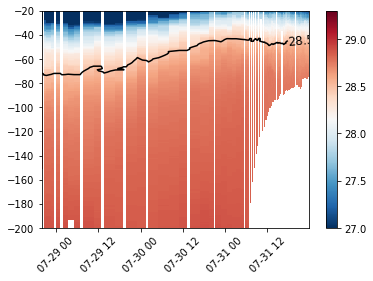

In [632]:

X, Y = np.meshgrid(ds_g.TIME.values, dd)

plt.pcolormesh(X, -Y, dens_interp2 -1000, cmap='RdBu_r', vmin=27, vmax=29.3)
plt.colorbar()
CS = plt.contour(X, -Y, dens_interpc -1000, [28.5], colors='black')
plt.ylim((-200,-20))
plt.clabel(CS, inline=True, fontsize=12)
plt.xticks(rotation=45)
plt.xlim((X.min(), X.max()))
# # gli_interp2.shape
# for i in range(ds_g.TIME.shape[0]):
#     max_level = int(ds_g.PRES[i,:].max().values.round())
#     min_level = int(ds_g.PRES[i,:].min().values.round())
    
#     dens_interp2[max_level:,i] = np.nan; dens_interp2[:min_level+1,i] = np.nan

#### Use Gliders SOCIB

In [682]:
# ds_gs = xr.open_dataset('http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep01-scb_sldeep001/L2/2017/dep0024_sdeep01_scb-sldeep001_L2_2017-05-10_data_dt.nc')
# ds_gs2 = ds_gs.sel(time=slice(datetime(2017,4,13), datetime(2017,5,25)))

ds_gs = xr.open_dataset('http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L2/2017/dep0009_sdeep04_scb-sldeep004_L2_2017-09-13_data_dt.nc')
ds_gs2 = ds_gs.sel(time=slice(datetime(2017,10,18), datetime(2017,11,1)))

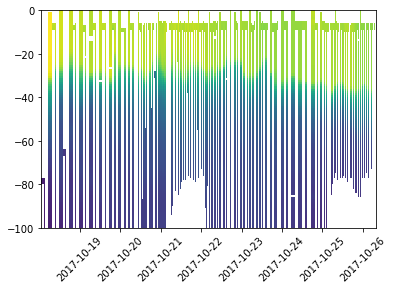

In [683]:

plt.pcolormesh(ds_gs2.time.values, -ds_gs2.depth.values, ds_gs2.temperature.values.T)
plt.xticks(rotation=45)
plt.ylim((-100,0))
plt.show()

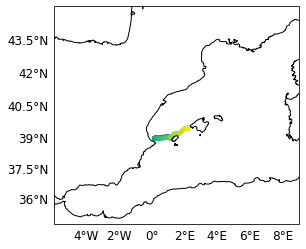

In [616]:
ax, gl = tools.make_map()
plt.scatter(ds_gs2.longitude, ds_gs2.latitude, 10, ds_gs2.time, transform=gl.crs) 

### Interpolate WMOP to Glider obs

In [617]:
import pyroms
from scipy.interpolate import interp1d

file_date = glob(F"{simulations['CR']}*avg*")[0]

grd = pyroms.grid.get_ROMS_grid('grid', hist_file=file_date, grid_file=file_date)
zeta = grd.vgrid.z_r[:]

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


In [618]:
t_interp = {}
s_interp = {}
rmsd_temp = {}
rmsd_salt = {}

# Mask for points at which there are Glider Obs
mask_gli = (ds_gs2.temperature.values.T / ds_gs2.temperature.values.T)
    
tmin_gli = pd.to_datetime(str(ds_gs2.time.min().values)).strftime('%Y%m%d')
tmax_gli = pd.to_datetime(str(ds_gs2.time.max().values)).strftime('%Y%m%d')
print(F"Calculating RMSD for SOCIB Glider in Ibiza Channel between {tmin_gli} and {tmax_gli}")

for sim in simulations:

    t_interp[sim] = np.empty_like( ds_gs2.temperature )
    s_interp[sim] = np.empty_like( ds_gs2.temperature )

    for nt in tqdm(range(ds_gs2.time.shape[0]) ):
        datestr = pd.to_datetime(str(ds_gs2.time[nt].values)).strftime('%Y%m%d')

        # Load WMOP
        file_date = glob(F"{simulations[sim]}*{datestr}*avg*")[0]
        ds_date = xr.open_dataset(file_date)

        nlon = np.argmin(np.abs(ds_date.lon_rho[0,:].values - ds_gs2.longitude[nt].values))
        nlat = np.argmin(np.abs(ds_date.lat_rho[:,0].values - ds_gs2.latitude[nt].values))

        z_obs = ds_gs2.depth
        z_roms = zeta[:,nlat,nlon]
        z_roms = -z_roms

        # Interpolate
        ft = interp1d(z_roms, ds_date.temp[0,:,nlat,nlon].values, fill_value="extrapolate")
        t_interp[sim][nt,:] = ft(z_obs)

        fs = interp1d(z_roms, ds_date.salt[0,:,nlat,nlon].values, fill_value="extrapolate")
        s_interp[sim][nt,:] = fs(z_obs)

    rmsd_temp[sim] = (np.sqrt( np.nanmean( (t_interp[sim] - ds_gs2.temperature)**2 )))
    rmsd_salt[sim] = (np.sqrt( np.nanmean( (s_interp[sim] - ds_gs2.salinity)**2 )))

    print(sim)
    print(F"\tTemp RMSD = {rmsd_temp[sim]:0.3f}")
    print(F"\tSalt RMSD = {rmsd_salt[sim]:0.3f}")
print("")

  0%|          | 0/1496 [00:00<?, ?it/s]

Calculating RMSD for SOCIB Glider in Ibiza Channel between 20171001 and 20171026


  0%|          | 0/1496 [00:00<?, ?it/s]

CR
	Temp RMSD = 0.887
	Salt RMSD = 0.363


  0%|          | 0/1496 [00:00<?, ?it/s]

noGLI
	Temp RMSD = 0.877
	Salt RMSD = 0.244


100%|██████████| 1496/1496 [01:41<00:00, 14.67it/s]


GLI
	Temp RMSD = 0.898
	Salt RMSD = 0.218



In [479]:
output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/Glider-vs-WMOP_profiles/Glider-WMOP_profile_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_{sim}_simulation.png'
output_filename

'/LOCALDATA/Plots/EuroSea/WP4/Assessment/Glider-vs-WMOP_profiles/Glider-WMOP_profile_Eurosea_reanalysis_2017_20170510-20170524_GLI.png'

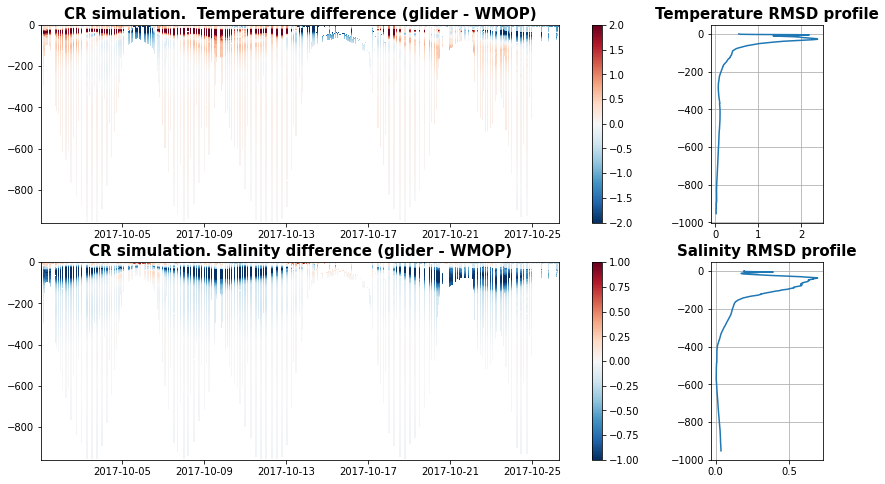

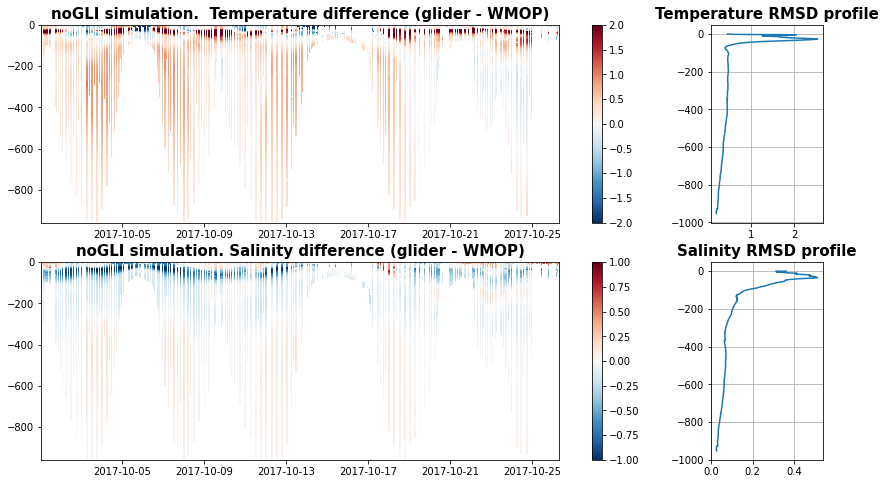

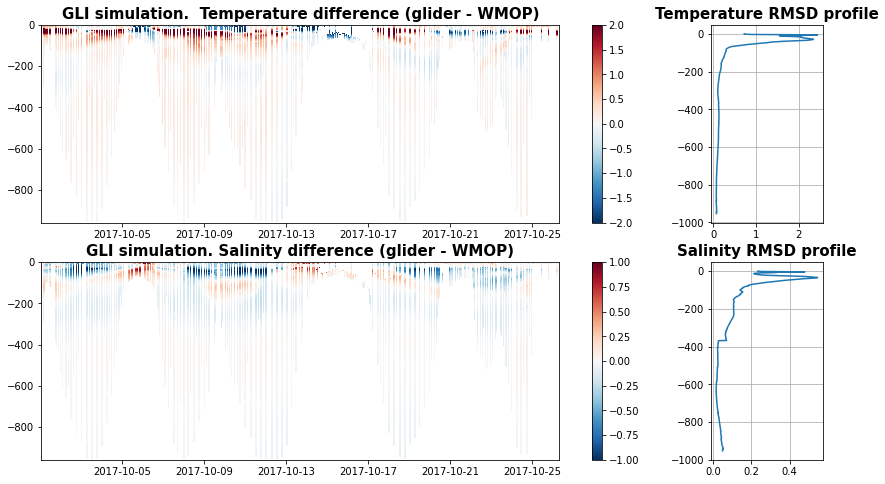

In [619]:
import matplotlib.gridspec as gridspec


xp, yp = ds_gs2.time.values, -ds_gs2.depth.values

nt, nz = ds_gs2.temperature.shape

salt_glider = ds_gs2.salinity.values
ptemp_glider = sw.ptmp( ds_gs2.salinity.values, ds_gs2.temperature.values, np.tile(ds_gs2.depth.values,[nt,1]) )

for sim in simulations:

    fig = plt.figure( figsize=(14,8))
    gs = gridspec.GridSpec(2, 6)

    ax1 = fig.add_subplot(gs[0, :-1])
    p1 = ax1.pcolormesh( xp, yp, ptemp_glider.T - t_interp[sim].T, vmin=-2, vmax=2, cmap='RdBu_r')
    # plt.xticks(rotation=45)
    plt.colorbar(p1)
    # plt.ylim((-200,0))
    plt.title(F"{sim} simulation.  Temperature difference (glider - WMOP)", fontsize=15, fontweight='bold')

    ax2 = fig.add_subplot(gs[0, -1])
    ax2.plot( np.sqrt( np.nanmean((ptemp_glider - t_interp[sim])**2, axis=0) ), yp) 
    plt.title('Temperature RMSD profile', fontsize=15, fontweight='bold')
    plt.grid()

    ax3 = fig.add_subplot(gs[1, :-1])
    p3 = ax3.pcolormesh( xp, yp, salt_glider.T - s_interp[sim].T, vmin=-1, vmax=1, cmap='RdBu_r')
    plt.colorbar(p3)
    plt.title(F"{sim} simulation. Salinity difference (glider - WMOP)", fontsize=15, fontweight='bold')

    ax2 = fig.add_subplot(gs[1, -1])
    ax2.plot( np.sqrt( np.nanmean((salt_glider - s_interp[sim])**2, axis=0) ), yp) 
    plt.title('Salinity RMSD profile', fontsize=15, fontweight='bold')
    # plt.ylim((-1000,0))
    plt.grid()
    
    # output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/Glider-vs-WMOP_profiles/Glider-WMOP_profile_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_{sim}_simulation.png'
    # fig.savefig(output_filename, dpi=250, transparent=False, facecolor="w")

In [695]:
strdate_min = pd.to_datetime(ds_gs2.time.min().values).strftime('%Y%m%d')
strdate_max = pd.to_datetime(ds_gs2.time.max().values).strftime('%Y%m%d')

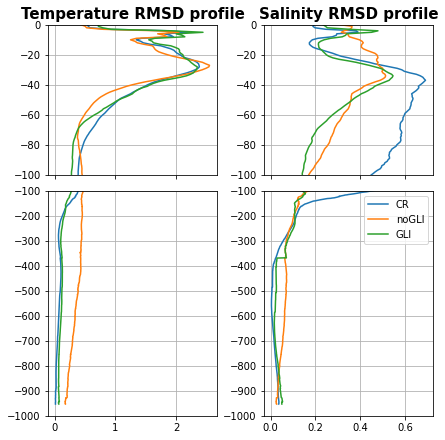

In [628]:
from matplotlib.gridspec import GridSpec
xp, yp = ds_gs2.time.values, -ds_gs2.depth.values

nt, nz = ds_gs2.temperature.shape

salt_glider = ds_gs2.salinity.values
ptemp_glider = sw.ptmp( ds_gs2.salinity.values, ds_gs2.temperature.values, np.tile(ds_gs2.depth.values,[nt,1]) )
# ptemp_glider = ds_gs2.temperature.values

fig = plt.figure(figsize=(6,6), constrained_layout=True)
gs = GridSpec(5, 4, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0:2, 2:])    
ax3 = fig.add_subplot(gs[2:, :2])
ax4 = fig.add_subplot(gs[2:, 2:])

for sim in simulations:

    ax1.plot( np.sqrt( np.nanmean((ptemp_glider - t_interp[sim]*mask_gli.T)**2, axis=0) ), yp) 
    ax3.plot( np.sqrt( np.nanmean((ptemp_glider - t_interp[sim]*mask_gli.T)**2, axis=0) ), yp, label=sim) 
    ax2.plot( np.sqrt( np.nanmean((salt_glider - s_interp[sim]*mask_gli.T)**2, axis=0) ), yp) 
    ax4.plot( np.sqrt( np.nanmean((salt_glider - s_interp[sim]*mask_gli.T)**2, axis=0) ), yp, label=sim) 
    
    # plt.ylim((-1000,0))
ax1.set_title('Temperature RMSD profile', fontsize=15, fontweight='bold')
ax2.set_title('Salinity RMSD profile', fontsize=15, fontweight='bold')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_ylim((-100,0))
ax2.set_ylim((-100,0))
ax3.set_ylim((-1000,-100))
ax4.set_ylim((-1000,-100))
plt.legend()    
plt.show()    
    # output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/Glider-vs-WMOP_profiles/Glider-WMOP_profile_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_{sim}_simulation.png'
    # fig.savefig(output_filename, dpi=250, transparent=False, facecolor="w")

## 4 - Check Sections 
    (Plot Density and isopicnals from Glider and compare to Model)

### Plot Density

In [82]:
import seawater as sw

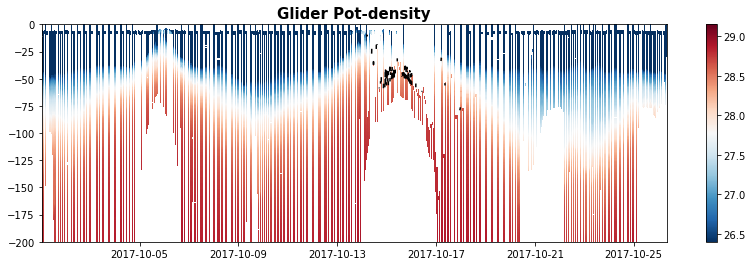

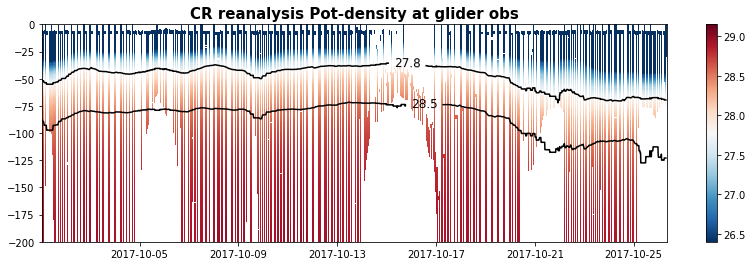

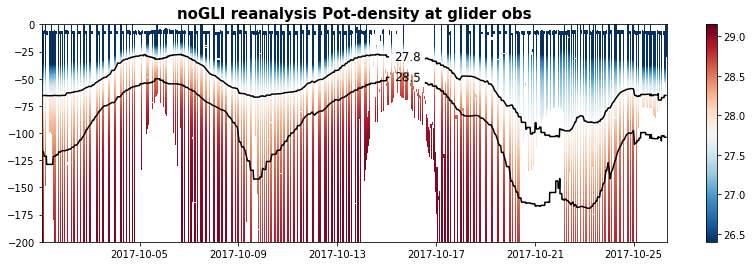

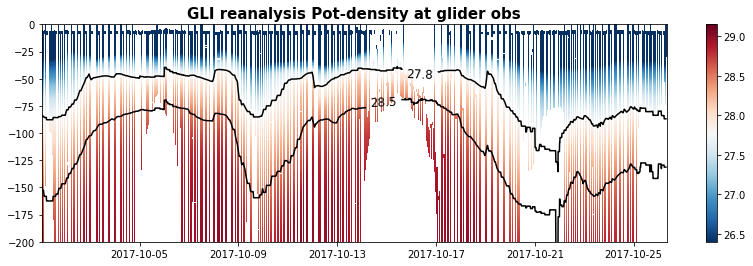

In [629]:
xp, yp = ds_gs2.time.values, -ds_gs2.depth.values
dep = np.tile(ds_gs2.depth.values,[nt,1])
dens_gli = sw.dens0(ds_gs2.salinity, ds_gs2.temperature ) - 1000

dens_wmop = defaultdict(list)

fig = plt.figure(figsize=(14,4))
plt.pcolormesh( xp, yp, dens_gli.T, cmap='RdBu_r', vmin=26.4, vmax=29.15)
# plt.xticks(rotation=45)
plt.colorbar()
CS = plt.contour(xp, yp, dens_gli.T, [28.5], colors='black')
plt.clabel(CS, inline=True, fontsize=12)
CS = plt.contour(xp, yp, dens_gli.T, [27.8], colors='black')
plt.clabel(CS, inline=True, fontsize=12)
plt.ylim((-200,0))
plt.title(F"Glider Pot-density", fontsize=15, fontweight='bold')
output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/Density_profiles/Glider-WMOP_density_profile_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_observations.png'
fig.savefig(output_filename, dpi=250, transparent=False, facecolor="w")

for sim in simulations:

    dens_wmop[sim] = sw.dens0(s_interp[sim], t_interp[sim]) - 1000
    
    fig = plt.figure(figsize=(14,4))

    plt.pcolormesh( xp, yp, dens_wmop[sim].T * mask_gli, cmap='RdBu_r', vmin=26.4, vmax=29.15)
    # plt.xticks(rotation=45)
    plt.colorbar()
    CS = plt.contour(xp, yp, dens_wmop[sim].T, [28.5], colors='black')
    plt.clabel(CS, inline=True, fontsize=12)
    CS = plt.contour(xp, yp, dens_wmop[sim].T, [27.8], colors='black')
    plt.clabel(CS, inline=True, fontsize=12)
    plt.ylim((-200,0))
    plt.title(F"{sim} reanalysis Pot-density at glider obs", fontsize=15, fontweight='bold')
    
    # output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/Density_profiles/Glider-WMOP_density_profile_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_{sim}_simulation.png'
    # fig.savefig(output_filename, dpi=250, transparent=False, facecolor="w")

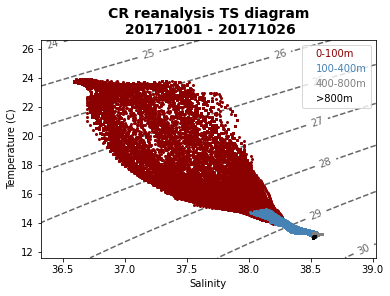

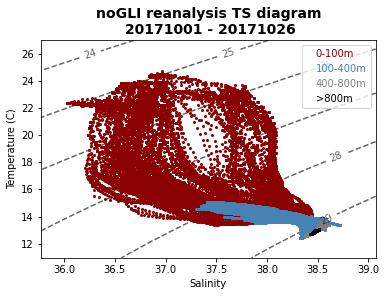

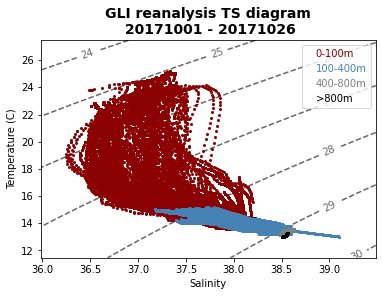

In [630]:
dep = np.tile(ds_gs2.depth.values,[nt,1]).flatten()
# dep = np.repeat(ds_gs2.depth.values, nt)

for sim in simulations:
    salt = s_interp[sim] * mask_gli.T
    temp = t_interp[sim] * mask_gli.T
    title = F"{sim} reanalysis TS diagram\n {tmin_gli} - {tmax_gli}"
    
    output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/TS_diagram/Glider-WMOP_TS_diagram_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_{sim}_simulation.png'
    
    plot_TS_diagram(salt.flatten(), temp.flatten(), dep, title=title, outfile=None)#output_filename)

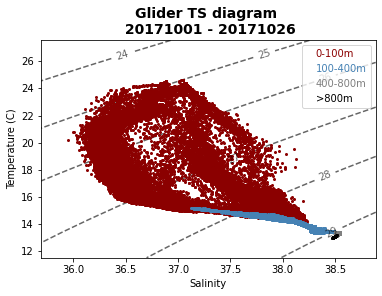

In [631]:
dep = np.tile(ds_gs2.depth.values,[nt,1]).flatten()
# dep = np.repeat(ds_gs2.depth.values, nt)

salt = ds_gs2.salinity.values.flatten()
temp = sw.ptmp(salt, ds_gs2.temperature.values.flatten(), dep) 

title = F"Glider TS diagram \n {tmin_gli} - {tmax_gli}"
    
output_filename = F'/LOCALDATA/Plots/EuroSea/WP4/Assessment/TS_diagram/Glider-WMOP_TS_diagram_Eurosea_reanalysis_2017_{tmin_gli}-{tmax_gli}_observations.png'

plot_TS_diagram(salt, temp, dep, title=title, outfile=None)#output_filename)

In [204]:
def plot_TS_diagram(salt, temp, dep, title=None, outfile=None):
    
    """ Plot TS diagram for Temperature and salinity values, given as array"""
    # Depth bins
    dep1=100;
    dep2=400;
    dep3=800;

    
    ii = (~np.isnan(temp)) | (~np.isnan(salt))
    salt = salt[ii]
    temp = temp[ii]
    dep = dep[ii]

    # Figure out boudaries (mins and maxs)
    smin = salt.min() - (0.01 * salt.min())
    smax = salt.max() + (0.01 * salt.max())
    tmin = temp.min() - (0.1 * temp.max())
    tmax = temp.max() + (0.1 * temp.max())

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))

    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))

    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(1,ydim-1,ydim)+tmin
    si = np.linspace(1,xdim-1,xdim)*0.1+smin

    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens(si[i],ti[j],0)

    # Substract 1000 to convert to sigma-t
    dens = dens - 1000

    # Plot data ***********************************************
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    CS = plt.contour(si,ti,dens, linewidth=0.2,# levels=4,
                     linestyles='dashed', colors='k', alpha=0.6)
    plt.clabel(CS, fontsize=10, inline=1, fmt='%1.0f') # Label every second level


    ndep1 = (dep <= dep1)
    ndep2 = (dep > dep1) & (dep <= dep2)
    ndep3 = (dep > dep2) & (dep <= dep3)
    ndep4 = (dep > dep3)
    
    ax1.plot(salt[ndep1], temp[ndep1],'o', c='darkred',markersize=2, label='0-100m')
    ax1.plot(salt[ndep2], temp[ndep2],'o', c='steelblue',markersize=2, label='100-400m')
    ax1.plot(salt[ndep3], temp[ndep3],'o', c='grey',markersize=2, label='400-800m')
    ax1.plot(salt[ndep4], temp[ndep4],'o', c='black',markersize=2, label='>800m')
    

    ax1.set_xlabel('Salinity')
    ax1.set_ylabel('Temperature (C)')
    ax1.set_title(title, fontsize=14, fontweight='bold')
    plt.legend(labelcolor='linecolor', markerscale=0, handletextpad=-1.0, handlelength=None)
    
    if outfile:
        fig1.savefig(outfile, dpi=250, transparent=False, facecolor="w")


In [357]:
file_slocum_1='http://thredds.priv.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2022/dep0005_sdeep06_scb-sldeep006_L2_2022-02-09_data_rt.nc';
ds_sloc = xr.open_dataset(file_slocum_1)

In [388]:
ts = ds_sloc.temperature.values.flatten()
ss = ds_sloc.salinity.values.flatten()
ds = np.tile(ds_sloc.depth.values,[ds_sloc.time.shape[0],1]).flatten()
times = np.repeat(ds_sloc.time.values, ds_sloc.depth.shape[0])

ii = (~np.isnan(ts) ) & (~np.isnan(ss))
ts = ts[ii]; 
ss = ss[ii]; 
ds = ds[ii]
times = times[ii]

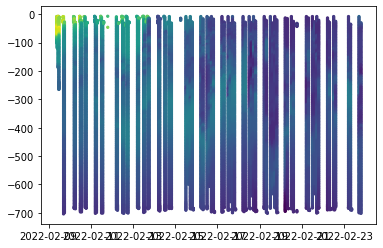

In [391]:
plt.scatter(times, -ds, 5,  ts)

In [396]:
ds_sloc.temperature[i,:]

<xarray.DataArray 'temperature' (depth: 698)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * depth      (depth) float64 7.0 8.0 9.0 10.0 11.0 ... 701.0 702.0 703.0 704.0
    latitude   float64 40.71
    longitude  float64 3.822
    time       datetime64[ns] 2022-02-24T03:47:55.010988032
Attributes:
    long_name:         water temperature
    standard_name:     sea_water_temperature
    units:             Celsius
    sources:           sci_water_temp
    grid_sources:      temperature
    grid_coordinates:  profile_index depth
    grid_method:       index mean

## 5 - Validate Transport in Ibiza Channel
    Compare transport from model with Glider data (Heslop)
    
    An intense Northward transport from all water masses was seen in Glider Data for CanalesSEP2017 (13 Sep - 26 Oct) mission. Around 1.4 Sv

In [5]:
import pyroms

file_wmop = '/home/modelling/data/WMOP/WMOP_REANALYSIS/Outputs/EUROSEA_T4_GLIDERS/forecast_scratch/roms_WMOP_FORECAST_20170925_avg.nc'
grd = pyroms.grid.get_ROMS_grid('wmop', hist_file=file_wmop, grid_file=file_wmop)
z_w = grd.vgrid.z_w[:]
z_r = grd.vgrid.z_r[:]

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


In [6]:
import seawater as sw

In [8]:
# Define Section location
lon_min = 0.1
lon_max = 1.1
lat_min = 39.0

nlon_min = np.argmin(np.abs(grd.hgrid.lon[0,:] - lon_min))
nlon_max = np.argmin(np.abs(grd.hgrid.lon[0,:] - lon_max))
nlat_min = np.argmin(np.abs(grd.hgrid.lat[:,0] - lat_min))

# Get Depths from section
z_section = z_r[:,nlat_min, nlon_min:nlon_max]
z_section_diff = np.diff(z_w[:,nlat_min, nlon_min:nlon_max], axis=0)

lon_section = grd.hgrid.lon[nlat_min, nlon_min:nlon_max]
dist_x = sw.dist(lat_min, lon_section)[0]

v_section = {}
transport_section = {}

for sim in ['FreeRun', 'GLIDERS', 'noGLIDERS']:
    
    files_monthly_mean = glob(F"/LOCALDATA/Data/EuroSea_WP4_Reanalysis_mean/{sim}/*")
    files_monthly_mean.sort()
    
    # Load file for October 2017 
    ds_wmop = xr.open_dataset(files_monthly_mean[9])
    
    # Get velocity in Section
    v_section[sim] = ds_wmop.v[0,:,nlat_min, nlon_min:nlon_max].values
    # Calculate transport in Section
    transport_section[sim] = z_section_diff * dist_x[0] * 1000 * v_section[sim] / 1e6
    
    print(F"Mean transport across IC section October 2017 for {sim} = {np.nansum(transport_section[sim]):0.2f} Sv")

Mean transport across IC section October 2017 for FreeRun = 0.45 Sv
Mean transport across IC section October 2017 for GLIDERS = 1.09 Sv
Mean transport across IC section October 2017 for noGLIDERS = 1.35 Sv


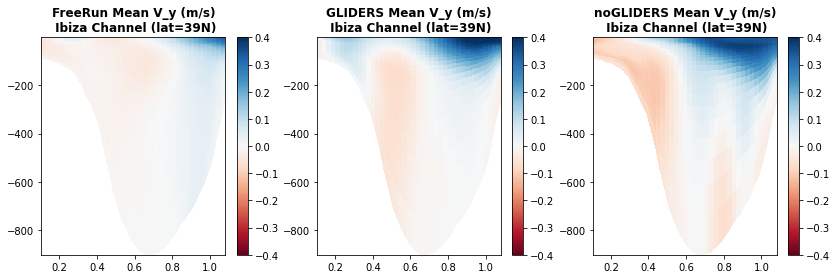

In [15]:
fig_transport = plt.figure(figsize=(14,4))

for i, sim in enumerate(['FreeRun', 'GLIDERS', 'noGLIDERS']):
    
    plt.subplot(1,3,i+1)
    plt.pcolormesh(lon_section, z_section, v_section[sim], vmin=-0.4, vmax=0.4, cmap='RdBu')
    plt.colorbar()
    plt.title(F'{sim} Mean V_y (m/s)\n Ibiza Channel (lat=39N)', fontsize=12, fontweight='bold')
    
plt.show()

In [16]:
fig_transport.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/mean_transport_Eurosea_reanalysis_Canales_sep-oct_2017_sections.png', 
                         dpi=250, transparent=False, facecolor="w")

### Transport Time-series

In [9]:
transport_serie = {}

for sim in simulations:
    
    files_sep = glob(F"{simulations[sim]}*201709[1-3]*avg*")
    files_oct = glob(F"{simulations[sim]}*201710*avg*")
    files_period = files_sep + files_oct
    files_period.sort()
    files_period = files_period[3:-5]
    
    transport_serie[sim] = []
    
    for file in files_period:
        # Load file for October 2017 
        ds_wmop = xr.open_dataset(file)

        # Get velocity in Section
        v_section[sim] = ds_wmop.v[0,:,nlat_min, nlon_min:nlon_max].values
        # Calculate transport in Section
        transport_section[sim] = z_section_diff * dist_x[0] * 1000 * v_section[sim] / 1e6

        transport_serie[sim].append(np.nansum(transport_section[sim]) )

    print(F"Mean transport across IC section October 2017 for {sim} = {np.nanmean(transport_serie[sim]):0.2f} Sv")

Mean transport across IC section October 2017 for CR = 0.43 Sv
Mean transport across IC section October 2017 for noGLI = 1.03 Sv
Mean transport across IC section October 2017 for GLI = 0.96 Sv


CR
    mean transport = 0.43 Sv

noGLI
    mean transport = 1.03 Sv

GLI
    mean transport = 0.96 Sv



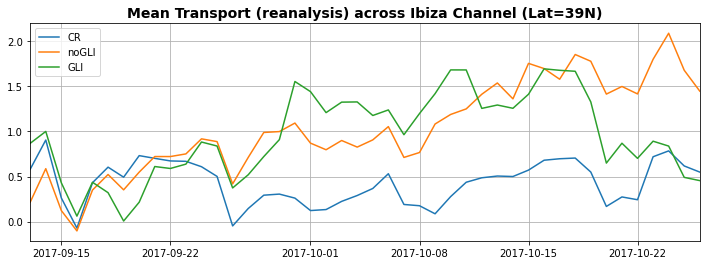

In [10]:
transport_serie[sim]
date_ini = datetime(2017,9,13)
dates_transport = [date_ini + timedelta(days=i) for i in range(len(files_period))]

fig_transport = plt.figure(figsize=(12,4))
for sim in simulations:
    print(sim)
    print(F"    mean transport = {np.nanmean(transport_serie[sim]):0.2f} Sv")
    print("")
    plt.plot(dates_transport, transport_serie[sim], label=sim)

plt.title(F"Mean Transport (reanalysis) across Ibiza Channel (Lat=39N)", fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.xlim((dates_transport[0], dates_transport[-1]))
plt.show()
    
    

In [929]:
fig_transport.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/mean_transport_Eurosea_reanalysis_Canales_sep-oct_2017.png', 
                         dpi=250, transparent=False, facecolor="w")

### Glider transport Time-series (by Mélanie)

In [16]:
import scipy.io as sio

In [50]:
glider_transport_files = glob('/LOCALDATA/Data/Glider_transports_IC/Melanie/*')
glider_transport_files

['/LOCALDATA/Data/Glider_transports_IC/Melanie/glider_canalesJul2017_transportGV_dt_IbizaChannel.mat',
 '/LOCALDATA/Data/Glider_transports_IC/Melanie/glider_canalesMay2017_transportGV_dt_IbizaChannel.mat',
 '/LOCALDATA/Data/Glider_transports_IC/Melanie/glider_canalesMar2017_transportGV_dt_IbizaChannel.mat',
 '/LOCALDATA/Data/Glider_transports_IC/Melanie/glider_canalesNov2017_transportGV_dt_IbizaChannel.mat',
 '/LOCALDATA/Data/Glider_transports_IC/Melanie/glider_canalesSep2017_transportGV_dt_IbizaChannel.mat']

In [51]:
for file in glider_transport_files:
    
    print(file.split('/')[-1].split('_')[1])
    glider_transport = sio.loadmat(file)
    # mat = loadmat('measured_data.mat')  # load mat-file
    mdata =  glider_transport['transports']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciPy reads in structures as structured NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convenience make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    # Reconstruct the columns of the data table from just the time series

    waterindex = [a[0] for a in ndata['waterIndex'][0] ]
    date = ndata['date']
    date_ind = [pd.to_datetime(date[i][0]-719529, unit='D') for i in range(date.shape[0])]
    
    df_wmass = pd.DataFrame(ndata['water'], columns=waterindex, index=date_ind)
    df_wtot = pd.DataFrame(ndata['total'], columns=['Tot-N', 'Tot-S'], index=date_ind)

    df = pd.concat([df_wmass,df_wtot], axis=1, join="inner")
    # print(df.shape)

canalesJul2017
canalesMay2017
canalesMar2017
canalesNov2017
canalesSep2017


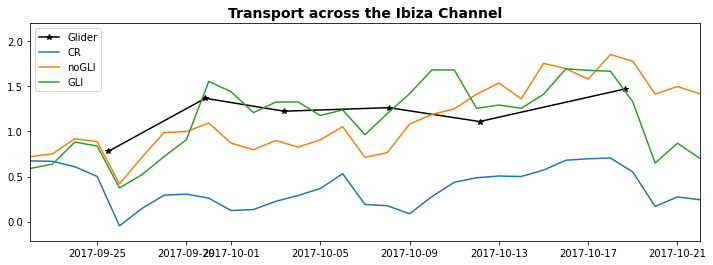

In [54]:
# Plot Transports

fig_transport = plt.figure(figsize=(12,4))
plt.plot(df['Tot-N'] + df['Tot-S'], 'k*-', label='Glider')
# plt.plot(df['Tot-N'] - df['Tot-S'], 'k*', label='Glider')
for sim in simulations:
    plt.plot(dates_transport, transport_serie[sim], label=sim)
    
plt.legend()
plt.title('Transport across the Ibiza Channel', fontsize=14, fontweight='bold')
plt.xlim((datetime(2017,9,22), datetime(2017,10,22)))

plt.show()

In [165]:
fig_transport.savefig(F'/home/jhernandez/public_html//mean_transport_Eurosea_reanalysis_Canales_sep-oct_2017.png', 
                         dpi=250, transparent=False, facecolor="w")

### Glider transport Time-series (by Baptiste)

In [56]:
glider_transport_files = glob('/mnt/waverider/data/Data/Observations/GLIDERS/Canales_Ibiza_Channel/Canales_processed_Baptiste_Nov2020/*/*transports_channel.mat')
glider_transport_files_melanie = glob('/LOCALDATA/Data/Glider_transports_IC/Melanie/*')


In [57]:
for file in glider_transport_files:
    
    print(file.split('/')[-2])#.split('_')[1])
    glider_transport = sio.loadmat(file)
    # mat = loadmat('measured_data.mat')  # load mat-file
    mdata =  glider_transport['transports']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciPy reads in structures as structured NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convenience make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    # Reconstruct the columns of the data table from just the time series

    waterindex = [a[0] for a in ndata['waterIndex'][0] ]
    date = ndata['date']
    date_ind = [pd.to_datetime(date[i][0]-719529, unit='D') for i in range(date.shape[0])]
    
    df_wmass = pd.DataFrame(ndata['water'], columns=waterindex, index=date_ind)
    df_wtot = pd.DataFrame(ndata['total'], columns=['Tot-N', 'Tot-S'], index=date_ind)

    df = pd.concat([df_wmass,df_wtot], axis=1, join="inner")
    print(df.shape)

canales_2017_11
(5, 12)
canales_2017_03
(10, 12)
canales_2017_07
(4, 12)
canales_2017_05
(10, 12)
canales_2017_09
(6, 12)


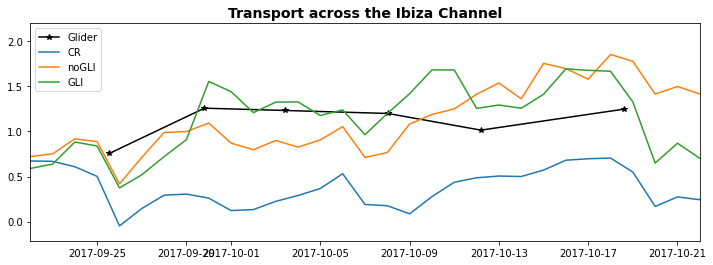

In [58]:
# Plot Transports

fig_transport = plt.figure(figsize=(12,4))
plt.plot(df['Tot-N'] + df['Tot-S'], 'k*-', label='Glider')
# plt.plot(df['Tot-N'] - df['Tot-S'], 'k*', label='Glider')
for sim in simulations:
    plt.plot(dates_transport, transport_serie[sim], label=sim)
    
plt.legend()
plt.title('Transport across the Ibiza Channel', fontsize=14, fontweight='bold')
plt.xlim((datetime(2017,9,22), datetime(2017,10,22)))

plt.show()

In [42]:
df_allyear_m = pd.DataFrame(columns=['AWo', 'AWr', 'LIW', 'WIW', 'WDW', 'AWo', 'AWr', 'LIW', 'WIW', 'WDW',
       'Tot-N', 'Tot-S'])

for file in glider_transport_files_melanie:
    
    # print(file.split('/')[-2])#.split('_')[1])
    print(file.split('/')[-1].split('_')[1])
    glider_transport = sio.loadmat(file)
    # mat = loadmat('measured_data.mat')  # load mat-file
    mdata =  glider_transport['transports']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciPy reads in structures as structured NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convenience make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    # Reconstruct the columns of the data table from just the time series

    waterindex = [a[0] for a in ndata['waterIndex'][0] ]
    date = ndata['date']
    date_ind = [pd.to_datetime(date[i][0]-719529, unit='D') for i in range(date.shape[0])]
    
    df_wmass = pd.DataFrame(ndata['water'], columns=waterindex, index=date_ind)
    df_wtot = pd.DataFrame(ndata['total'], columns=['Tot-N', 'Tot-S'], index=date_ind)

    df = pd.concat([df_wmass,df_wtot], axis=1, join="inner")
    
    df_allyear_m = pd.concat([df_allyear_m, df])

canalesJul2017
canalesMay2017
canalesMar2017
canalesNov2017
canalesSep2017


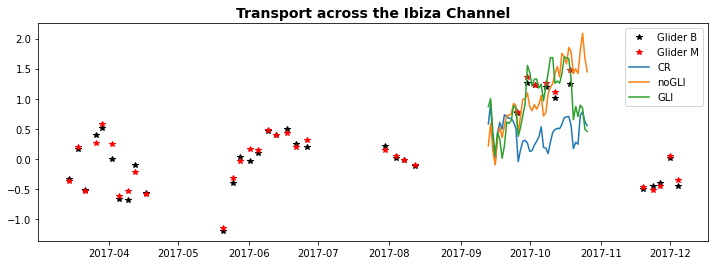

In [46]:
fig_transport = plt.figure(figsize=(12,4))
plt.plot(df_allyear['Tot-N'] + df_allyear['Tot-S'], 'k*', label='Glider B')
plt.plot(df_allyear_m['Tot-N'] + df_allyear_m['Tot-S'], 'r*', label='Glider M')
# plt.plot(df['Tot-N'] - df['Tot-S'], 'k*', label='Glider')
for sim in simulations:
    plt.plot(dates_transport, transport_serie[sim], label=sim)
    
plt.legend()
plt.title('Transport across the Ibiza Channel', fontsize=14, fontweight='bold')
# plt.xlim((datetime(2017,9,22), datetime(2017,10,22)))

plt.show()

## 6 - Check Eddy from Barcelona

In [4]:
import cmocean.cm as cm

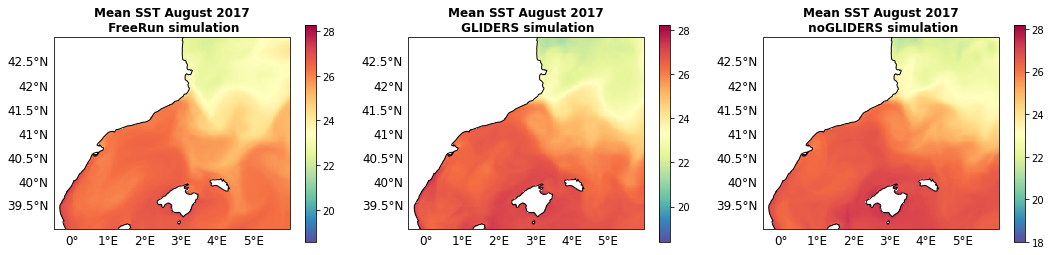

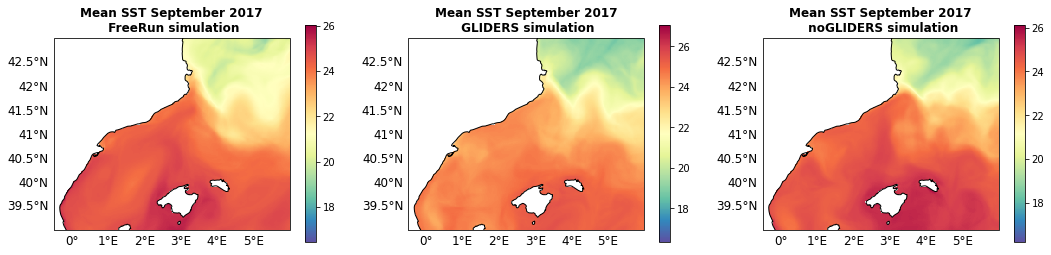

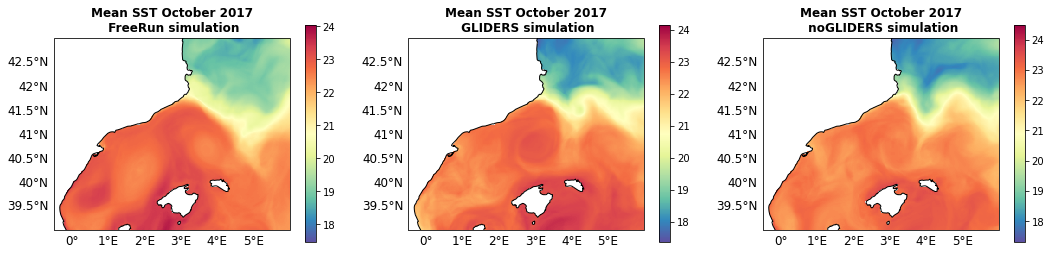

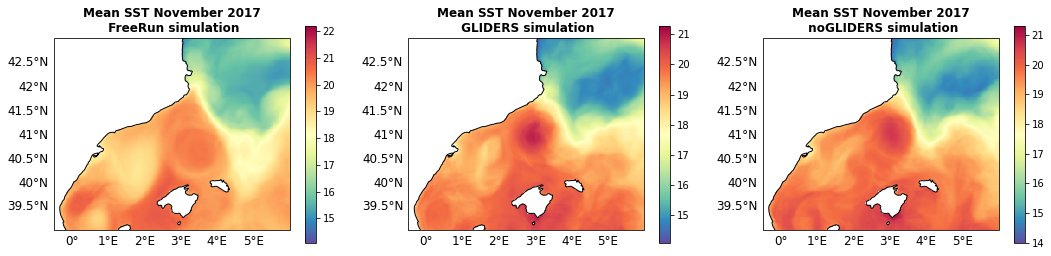

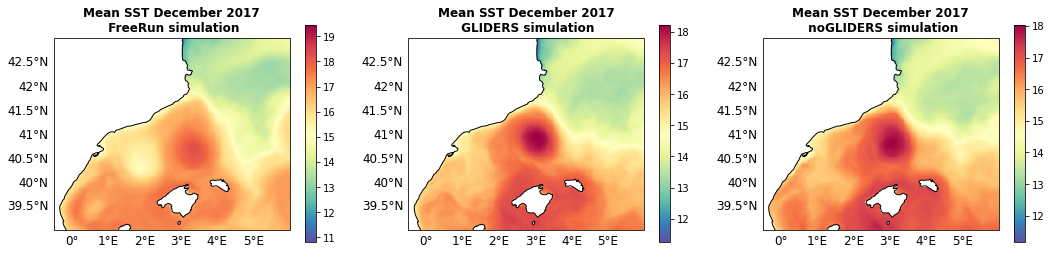

In [5]:
months = {'August':7, 'September':8, 'October':9, 'November':10, 'December':11}


for m in months:
    
    fig_sst = plt.figure(figsize=(18,4))

    for i, sim in enumerate(['FreeRun', 'GLIDERS', 'noGLIDERS']):

        files_monthly_mean = glob(F"/LOCALDATA/Data/EuroSea_WP4_Reanalysis_mean/{sim}/*")
        files_monthly_mean.sort()

        # Load file for October 2017 
        ds_wmop = xr.open_dataset(files_monthly_mean[months[m]])

        # plt.subplot(1,3,i+1)
        ax, gl = tools.make_map(subplot_dim=(1,3,i+1), limits=[-0.5,6,39,43] )
        plt.pcolormesh(ds_wmop.lon_rho, ds_wmop.lat_rho, ds_wmop.temp[0,-1,:,:],
                       transform=gl.crs, cmap='Spectral_r')#, vmin=18, vmax=25)
        plt.title(F"Mean SST {m} 2017\n {sim} simulation", fontsize=12, fontweight='bold')
        plt.colorbar()


    plt.show()
    #fig_sst.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/SST_eddie/Eurosea_reanalysis_{m}_2017_mean_SST_balearic_sea.png', 
     #                    dpi=250, transparent=False, facecolor="w")

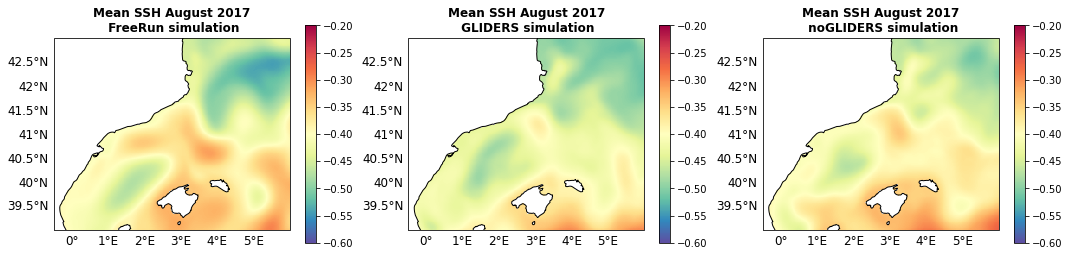

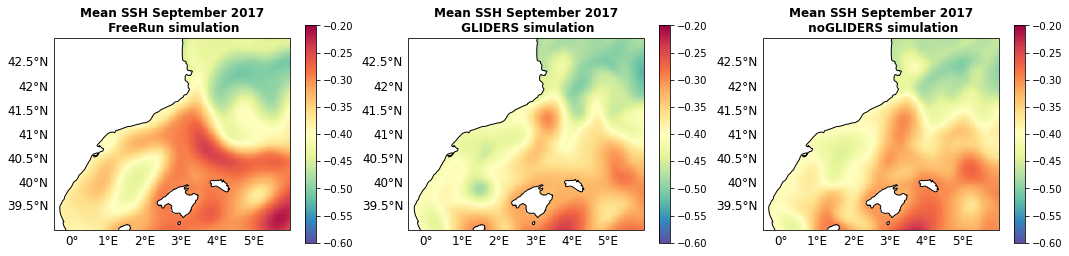

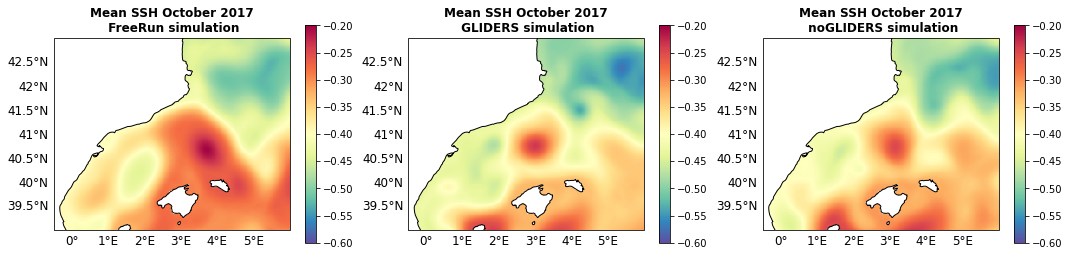

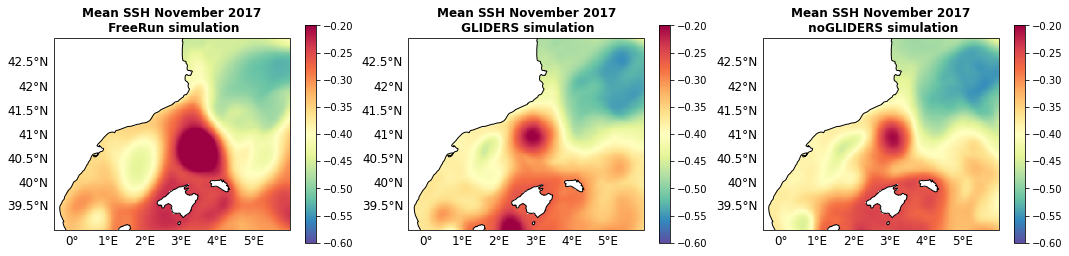

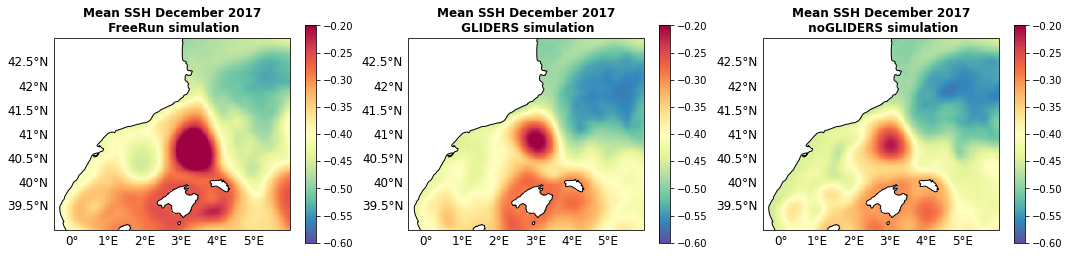

In [6]:
months = {'August':7, 'September':8, 'October':9, 'November':10, 'December':11}


for m in months:
    
    fig_ssh = plt.figure(figsize=(18,4))

    for i, sim in enumerate(['FreeRun', 'GLIDERS', 'noGLIDERS']):

        files_monthly_mean = glob(F"/LOCALDATA/Data/EuroSea_WP4_Reanalysis_mean/{sim}/*")
        files_monthly_mean.sort()

        # Load file for October 2017 
        ds_wmop = xr.open_dataset(files_monthly_mean[months[m]])

        # plt.subplot(1,3,i+1)
        ax, gl = tools.make_map(subplot_dim=(1,3,i+1), limits=[-0.5,6,39,43] )
        plt.pcolormesh(ds_wmop.lon_rho, ds_wmop.lat_rho, ds_wmop.zeta[0,:,:],
                       transform=gl.crs, cmap='Spectral_r', vmin=-0.6, vmax=-0.2)
        plt.title(F"Mean SSH {m} 2017\n {sim} simulation", fontsize=12, fontweight='bold')
        plt.colorbar()


    plt.show()
    #fig_ssh.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/SSH_eddie/Eurosea_reanalysis_{m}_2017_mean_SSH_balearic_sea.png', 
     #                    dpi=250, transparent=False, facecolor="w")

### Check eddie in observations

In [7]:
files_ssh_mmean = glob('/home/modelling/data/Data/Observations/ALTIMETRY/rep_map_sla/2017/*/monthly_mean/rep_med_allsat_map_sla_2017*_monthlymean.nc')
files_ssh_mmean.sort()

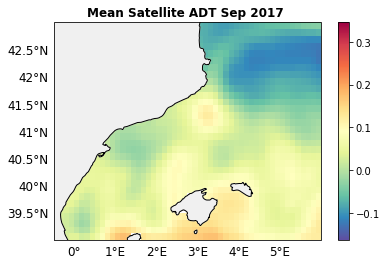

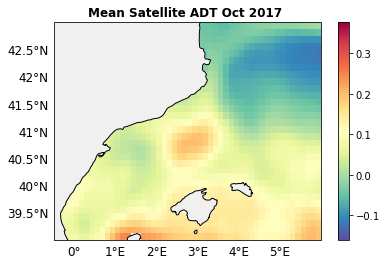

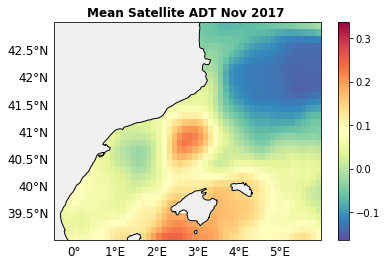

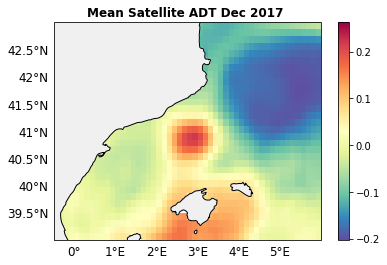

In [8]:
for file in files_ssh_mmean[8:]:
    ds = xr.open_dataset(file)
    month = pd.to_datetime(ds.time.values).strftime('%b')[0]

    fig_adt = plt.figure()
    ax, gl = tools.make_map(limits=[-0.5,6,39,43], continents=True )
    plt.pcolormesh(ds.longitude, ds.latitude, ds.adt[0,:,:], transform=gl.crs, cmap='Spectral_r')
    plt.title(F"Mean Satellite ADT {month} 2017 ", fontsize=12, fontweight='bold')
    plt.colorbar()
    plt.show()
    
    #fig_adt.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/ADT_satellite_{month}_2017_mean_SSH_balearic_sea.png', 
     #                    dpi=250, transparent=False, facecolor="w")

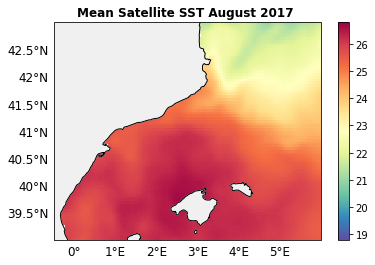

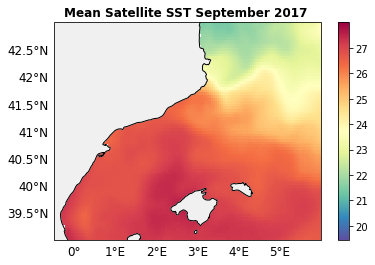

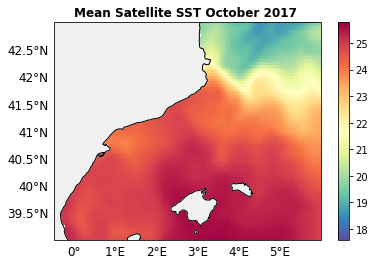

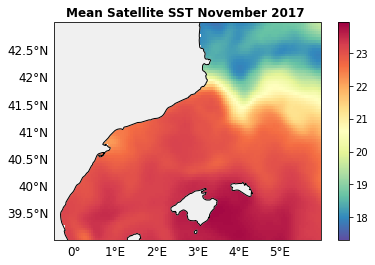

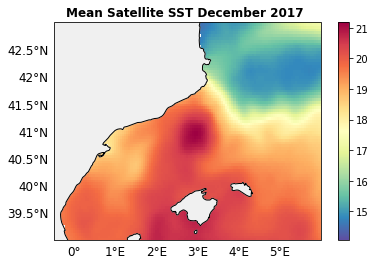

In [9]:
months = {'August':7, 'September':8, 'October':9, 'November':10, 'December':11}
for m in months:
    files_sst = glob(F'/home/modelling/data/Data/Observations/CMEMS-MED-SST/L4/rep_hr/2017/{months[m]:02}/*nc')
    files_sst.sort()
    
    ds = xr.open_mfdataset(files_sst)
    # ds = ds.where( (ds.lon<6) & (ds.lon>-0.5) & (ds.lat>-39) & (ds.lat<43) )
    
    fig_sst = plt.figure()
    ax, gl = tools.make_map(limits=[-0.5,6,39,43], continents=True )
    plt.pcolormesh(ds.lon, ds.lat, ds.analysed_sst.mean('time') - 273, transform=gl.crs, cmap='Spectral_r')
    plt.colorbar()
    plt.title(F"Mean Satellite SST {m} 2017 ", fontsize=12, fontweight='bold')
    
    
    plt.show()
    
    #fig_sst.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/SST_satellite_{m}_2017_mean_SSH_balearic_sea.png', 
     #                    dpi=250, transparent=False, facecolor="w")

### Check correlation between model and Observations in the area

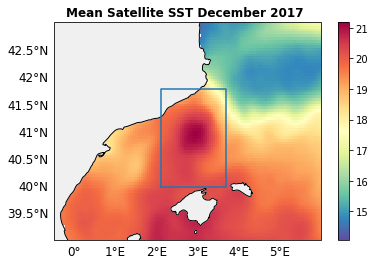

In [17]:
lims_an = [2.1, 3.7, 40.0, 41.8]

fig_sst = plt.figure()
ax, gl = tools.make_map(limits=[-0.5,6,39,43], continents=True )
plt.pcolormesh(ds.lon, ds.lat, ds.analysed_sst.mean('time') - 273, transform=gl.crs, cmap='Spectral_r')
plt.colorbar()
plt.title(F"Mean Satellite SST {m} 2017 ", fontsize=12, fontweight='bold')
plt.plot([lims_an[0], lims_an[1], lims_an[1], lims_an[0], lims_an[0]], 
          [lims_an[2], lims_an[2], lims_an[3], lims_an[3], lims_an[2]],
          transform=gl.crs)

plt.show()

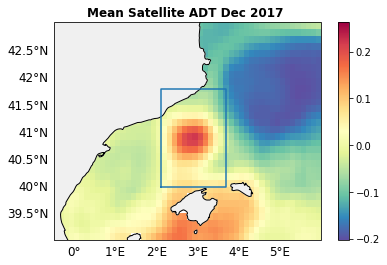

In [18]:
#for file in files_ssh_mmean[8:]:
ds = xr.open_dataset(file)
month = pd.to_datetime(ds.time.values).strftime('%b')[0]

fig_adt = plt.figure()
ax, gl = tools.make_map(limits=[-0.5,6,39,43], continents=True )
plt.pcolormesh(ds.longitude, ds.latitude, ds.adt[0,:,:], transform=gl.crs, cmap='Spectral_r')
plt.title(F"Mean Satellite ADT {month} 2017 ", fontsize=12, fontweight='bold')
plt.colorbar()

plt.plot([lims_an[0], lims_an[1], lims_an[1], lims_an[0], lims_an[0]], 
          [lims_an[2], lims_an[2], lims_an[3], lims_an[3], lims_an[2]],
          transform=gl.crs)


In [ ]:
fig_ssh = plt.figure(figsize=(18,4))

for i, sim in enumerate(['FreeRun', 'GLIDERS', 'noGLIDERS']):

    files_monthly_mean = glob(F"/LOCALDATA/Data/EuroSea_WP4_Reanalysis_mean/{sim}/*")
    files_monthly_mean.sort()

    # Load file for October 2017 
    ds_wmop = xr.open_dataset(files_monthly_mean[months[m]])

    # plt.subplot(1,3,i+1)
    ax, gl = tools.make_map(subplot_dim=(1,3,i+1), limits=[-0.5,6,39,43] )
    plt.pcolormesh(ds_wmop.lon_rho, ds_wmop.lat_rho, ds_wmop.zeta[0,:,:],
                   transform=gl.crs, cmap='Spectral_r', vmin=-0.6, vmax=-0.2)
    plt.title(F"Mean SSH {m} 2017\n {sim} simulation", fontsize=12, fontweight='bold')
    plt.colorbar()

    plt.plot([lims_an[0], lims_an[1], lims_an[1], lims_an[0], lims_an[0]], 
          [lims_an[2], lims_an[2], lims_an[3], lims_an[3], lims_an[2]],
          transform=gl.crs)

plt.show()